<a href="https://colab.research.google.com/github/AlirezaAhadipour/Wine-Review/blob/main/Wine_Review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub

In [7]:
df = pd.read_csv('wine-reviews.csv', usecols=['country', 'description', 'points', 'price', 'variety', 'winery'])
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


In [8]:
df = df.dropna(subset=['description', 'points'])

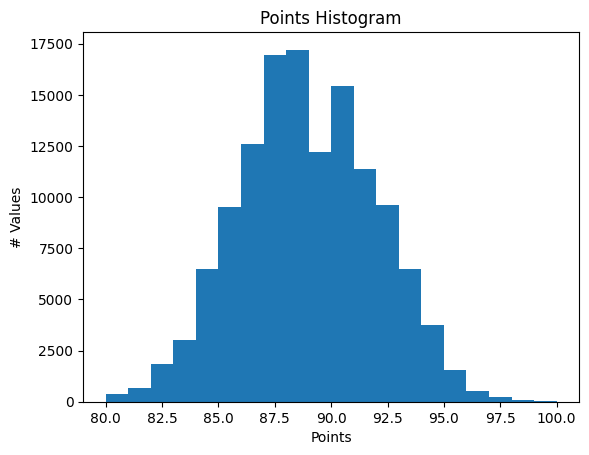

In [4]:
plt.hist(df.points, bins=20)
plt.title('Points Histogram')
plt.ylabel('# Values')
plt.xlabel('Points')
plt.show()

In [9]:
df['label'] = (df.points >= 90).astype(int)
df = df[['description', 'label']]
df

,description,label
0,"Aromas include tropical fruit, broom, brimston...",0
1,"This is ripe and fruity, a wine that is smooth...",0
2,"Tart and snappy, the flavors of lime flesh and...",0
3,"Pineapple rind, lemon pith and orange blossom ...",0
4,"Much like the regular bottling from 2012, this...",0
...,...,...
129966,Notes of honeysuckle and cantaloupe sweeten th...,1
129967,Citation is given as much as a decade of bottl...,1
129968,Well-drained gravel soil gives this wine its c...,1
129969,"A dry style of Pinot Gris, this is crisp with ...",1


In [10]:
train, val, test = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])

In [13]:
def df_to_dataset(dataframe, shuffle=True, batch_size = 1024):
  df = dataframe.copy()
  labels = df.pop('label')
  df = df['description']
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe) )
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf. data. AUTOTUNE)
  return ds

In [14]:
train_data = df_to_dataset(train)
val_data = df_to_dataset(val)
test_data = df_to_dataset(test)

In [15]:
list(train_data)[0]

(<tf.Tensor: shape=(1024,), dtype=string, numpy=
 array([b"Made in a more forward style than it used to be, Calera's '07 Jensen appeals for its lush raspberry, cherry, bacon, vanilla and sandalwood flavors. The acidity is just fine, and the tannins are soft and intricate. Lovely now, with a brief decant, and should develop for 6\xe2\x80\x938 years.",
        b'This easygoing, friendly wine features aromas of rose, violet and dark berry. On the palate, soft tannins lightly frame wild cherry and crushed raspberry flavors while a hint of vanilla adds interest. Drink through 2015.',
        b"A strong, extracted Pinot, lacking delicacy and finesse. It's enormous in jammy raspberries, cherries and liqueur, with plenty of sweet, toasty oak. High alcohol gives it a full body and a taste of glyceriney sweetness. Many will like its power and flash. Drink it over the next few years.",
        ...,
        b'This has fresh berry and flower aromas that lead to a healthy-feeling palate, which is fu

In [38]:
embedding = 'https://tfhub.dev/google/nnlm-en-dim50/2'
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)

In [39]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(1024, 50), dtype=float32, numpy=
array([[ 2.31142610e-01,  8.67347941e-02,  3.20255873e-04, ...,
        -3.91550958e-02, -3.52612525e-01,  1.83606759e-01],
       [ 4.78406429e-01, -2.25007504e-01,  7.86662921e-02, ...,
         2.85531551e-01, -1.93606153e-01,  1.43483847e-01],
       [ 3.11958641e-01, -3.75245184e-01, -8.27476084e-02, ...,
         1.60759717e-01, -4.07612115e-01, -1.11720420e-01],
       ...,
       [ 4.02750313e-01, -1.23055264e-01,  5.85340410e-02, ...,
         1.46255985e-01, -4.56493441e-03, -1.59990385e-01],
       [ 2.93159127e-01, -3.28474730e-01,  2.23804750e-02, ...,
         6.09255247e-02, -8.50568414e-02, -1.72022507e-01],
       [ 5.02199054e-01, -3.17114323e-01,  5.84687777e-02, ...,
         6.18102141e-02, -1.20861590e-01,  6.40576333e-02]], dtype=float32)>

In [28]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [31]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [32]:
model.evaluate(train_data)

102/102 [==============================] - 3s 19ms/step - loss: 0.6852 - accuracy: 0.5671


[0.6852292418479919, 0.5670924186706543]

In [34]:
history = model.fit(train_data, epochs=10, validation_data=val_data)

Epoch 1/10
102/102 [==============================] - 127s 1s/step - loss: 0.5437 - accuracy: 0.7134 - val_loss: 0.4026 - val_accuracy: 0.8106
Epoch 2/10
102/102 [==============================] - 121s 1s/step - loss: 0.3668 - accuracy: 0.8338 - val_loss: 0.3645 - val_accuracy: 0.8313
Epoch 3/10
102/102 [==============================] - 122s 1s/step - loss: 0.3244 - accuracy: 0.8563 - val_loss: 0.3579 - val_accuracy: 0.8346
Epoch 4/10
102/102 [==============================] - 122s 1s/step - loss: 0.3012 - accuracy: 0.8688 - val_loss: 0.3632 - val_accuracy: 0.8363
Epoch 5/10
102/102 [==============================] - 153s 2s/step - loss: 0.2842 - accuracy: 0.8776 - val_loss: 0.3621 - val_accuracy: 0.8360
Epoch 6/10
102/102 [==============================] - 164s 2s/step - loss: 0.2698 - accuracy: 0.8847 - val_loss: 0.3717 - val_accuracy: 0.8327
Epoch 7/10
102/102 [==============================] - 125s 1s/step - loss: 0.2578 - accuracy: 0.8912 - val_loss: 0.3742 - val_accuracy: 0.8337

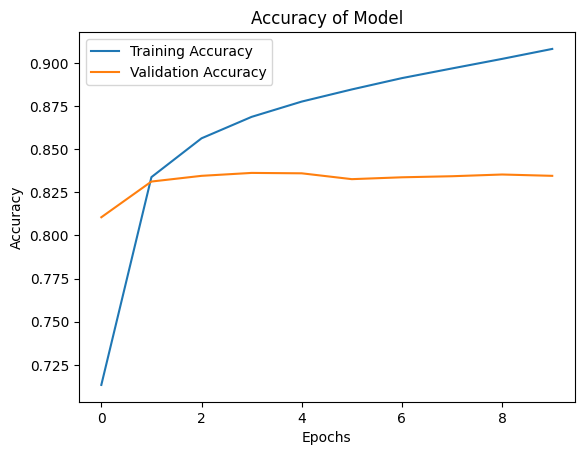

In [36]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy of Model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

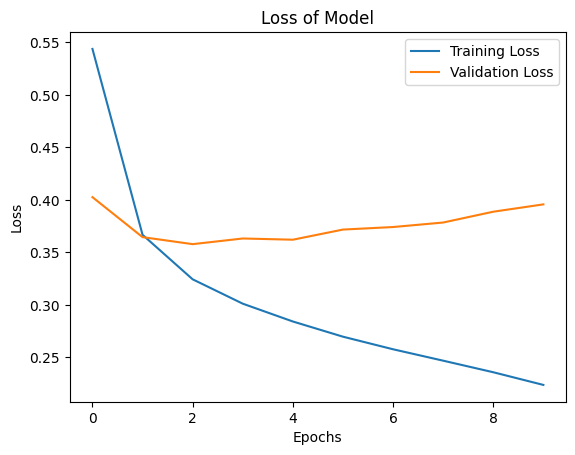

In [37]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss of Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Add DROPOUT

In [41]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [42]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [43]:
history = model.fit(train_data, epochs=5, validation_data=val_data)

Epoch 1/5
102/102 [==============================] - 122s 1s/step - loss: 0.6513 - accuracy: 0.6051 - val_loss: 0.5408 - val_accuracy: 0.7486
Epoch 2/5
102/102 [==============================] - 121s 1s/step - loss: 0.4959 - accuracy: 0.7652 - val_loss: 0.4000 - val_accuracy: 0.8180
Epoch 3/5
102/102 [==============================] - 121s 1s/step - loss: 0.4101 - accuracy: 0.8213 - val_loss: 0.3752 - val_accuracy: 0.8289
Epoch 4/5
102/102 [==============================] - 120s 1s/step - loss: 0.3733 - accuracy: 0.8433 - val_loss: 0.3683 - val_accuracy: 0.8321
Epoch 5/5
102/102 [==============================] - 121s 1s/step - loss: 0.3484 - accuracy: 0.8558 - val_loss: 0.3674 - val_accuracy: 0.8337


In [44]:
model.evaluate(test_data)

13/13 [==============================] - 2s 161ms/step - loss: 0.3779 - accuracy: 0.8265


[0.3779219090938568, 0.826511800289154]

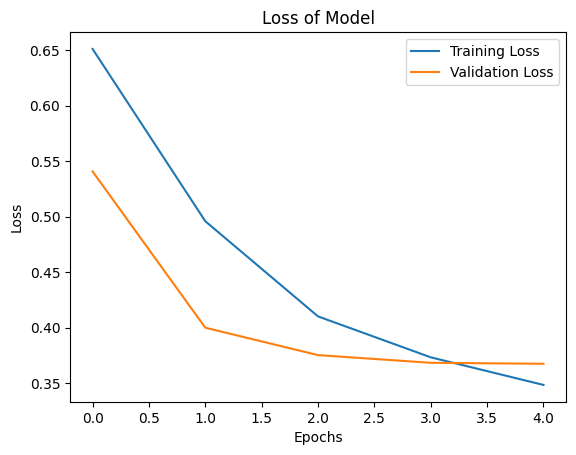

In [45]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss of Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### LSTM

In [47]:
encoder = tf.keras.layers.TextVectorization(max_tokens=2000)
encoder.adapt(train_data.map(lambda text, label: text))

In [48]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'and', 'the', 'a', 'of', 'with', 'this', 'is', 'wine',
       'flavors', 'in', 'to', 'it', 'its', 'on', 'fruit', 'aromas',
       'palate', 'that'], dtype='<U17')

In [49]:
model = tf.keras.Sequential()
model.add(encoder)
model.add(tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()), output_dim=32, mask_zero=True))
model.add(tf.keras.layers.LSTM(32))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [50]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [51]:
history = model.fit(train_data, epochs=5, validation_data=val_data)

Epoch 1/5
102/102 [==============================] - 55s 463ms/step - loss: 0.5377 - accuracy: 0.7196 - val_loss: 0.3768 - val_accuracy: 0.8267
Epoch 2/5
102/102 [==============================] - 47s 460ms/step - loss: 0.3692 - accuracy: 0.8370 - val_loss: 0.3509 - val_accuracy: 0.8393
Epoch 3/5
102/102 [==============================] - 46s 454ms/step - loss: 0.3513 - accuracy: 0.8449 - val_loss: 0.3424 - val_accuracy: 0.8435
Epoch 4/5
102/102 [==============================] - 47s 461ms/step - loss: 0.3450 - accuracy: 0.8470 - val_loss: 0.3421 - val_accuracy: 0.8429
Epoch 5/5
102/102 [==============================] - 47s 462ms/step - loss: 0.3397 - accuracy: 0.8498 - val_loss: 0.3428 - val_accuracy: 0.8440


In [52]:
model.evaluate(test_data)

13/13 [==============================] - 4s 286ms/step - loss: 0.3537 - accuracy: 0.8388


[0.3536696434020996, 0.8388213515281677]